#데이터 확인


In [1]:
from google.colab import drive
drive.mount('/content/drive')
#공유드라이브에서 데이터 업로드 

Mounted at /content/drive


In [2]:
import keras
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from collections import Counter
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img ,img_to_array

#필요한 모듈들 임포트

In [3]:
y_data_list = []
x_data_list = []
food_list = ['apple_pie', 'bibim', 'bosam', 'bread', 'fried_noodle', 'fried_rice', 'pancake','passion_fruit', 'peach', 'sandwich']
#음식 데이터 리스트

#이미지의 사이즈 가로세로 픽셀 128개씩, 컬러사진이므로 채널 RGB  3개
# 축소 시켜서 32*32
input_shape = (32,32,3)



# 전처리 및 Augmetaion



In [4]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")


In [5]:
for food in food_list:
  for number in range(1,101):

    img = cv2.imread(f"/content/drive/MyDrive/인지개/인공지능개론 데이터셋2/{food}{number}.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #food_list에 있는 각 음식에 대해 1부터 100까지의 숫자를 뒤에 붙인 파일 경로를 cv2.imread를 사용하여 읽어옴
    #cv2는 불러오는 이미지 순서가 bgr 바꿔줌
    #이미지 업로드

    #결측치 확인
    if img is None:
      print(f'{food}{number}.jpg is none')
      continue 

    #결측치 발생 -> img 라는 변수가 none 이라면 그 사진의 이름을 프린트
    #continue 사용해 none이면 다음 loop 돌게 함
    
    img = cv2.resize(img,(32,32))
    #이미지 resize, type -> ndarray(이미지 데이터가 여기서 수치화 됨)
    
    ###augmetation###

    img = img.reshape((1,32,32,3))
    i = 0
    for batch in datagen.flow(img, batch_size=1): # 배치 사이즈 1이라는건 이미지 처리를 한 장씩 한다는 뜻
      i += 1
      if i > 100:
        break # 한 장에 대해 100장씩 증강시키기 위해 위해 if문 넣음
      x_data_list.append(batch.reshape(32,32,3))
      y_data_list.append(food_list.index(food))

    #데이터 증강은 datagen.flow 함수를 사용하여 이미지를 변형시키는 작업을 수행하고, 변형된 이미지와 해당 음식의 인덱스를 각각 x_data_list와 y_data_list에 추가함


    #각각의 food에 따라 숫자로 통일하여 타겟 인덱싱

    img = None # 초기화하면서 반복
  
(x_data, y_data) = (np.array(x_data_list), np.array(y_data_list)) # 준비한 데이터를 어레이로 모두 바꿔주기

In [6]:
print(x_data.shape)
print(y_data.shape)
# 10만장 찍히는걸 확인 가능
for i in x_data:
  if not i.any():
    print('none')

(100000, 32, 32, 3)
(100000,)


In [7]:
x, x_test, y, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
#훈련:검증:테스트 = 16:4:5 비율로 나눔
#train_test_split 함수를 사용하여 데이터를 훈련, 테스트, 검증 세트로 나누는 것은 모델의 일반화 성능을 평가하고, 오버피팅(overfitting)을 방지할 수 있음 

x_train_scaled = x_train.astype("float32")/ 255.
x_test_scaled = x_test.astype("float32")/ 255.
x_val_scaled = x_val.astype("float32")/ 255.
#데이터들마다 범위가 다르니까 비교하기 편리하게 하기 위해 [0,1]범위로 바꾸는 것
#스케일링 진행 

num_classes = 10

y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
y_val = keras.utils.to_categorical(y_val,num_classes)
#타켓데이터를 이진법 표현 위해 원핫벡터 생성 000000001 / 0000000010 / 0000000100 이런 식으로 10자리 이진수로 라벨링 되는 것


# CNN모델(합성곱 신경망) 훈련

In [9]:
# 랜덤 고정
np.random.seed(1) 
tf.random.set_seed(1)


# 모델 구성
# 합성곱층 3개 풀링층 3개 정규화층 3개 플래튼층 1개 은닉층 2개 드롭아웃층 2개 출력층 1개 -> 총 매개변수 652874 / 드롭아웃 파라미터 448
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)), # 3*3 커널 32개로 32*32 이미지 이동 -> 패딩 진행 -> 32*32*32 feature map 생성 / 가중치 함수 relu
    layers.BatchNormalization(), # 각각에 대해 정규화 진행
    layers.MaxPooling2D((2, 2)), # 맥스 풀링 -> 16*16*32 feature map 생성
    layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'), # 여기서부터 커널 개수만 늘리면서 반복 진행
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 특성맵 자체를 쭉 펴주기 -> 펴면 특성맵 하나하나가 각각의 뉴런으로 들어가야되니까 총 2048개가 되는거지
    layers.Dense(256, activation='relu'), # 은닉층을 거치면서 뉴런의 개수 줄여나가기
    layers.Dropout(0.4), # 과적합 방지를 위해 전체 뉴런의 40프로를 drop 시키기
    layers.Dense(128, activation='relu'), # 똑같이 은닉층 한 번 거치기
    layers.Dropout(0.4), # 똑같이 드롭아웃 한 번 더 진행
    layers.Dense(10, activation='softmax')]) # 데이터의 클래스가 10개니까 출력층에서 뉴런 10개로 정하기 / 출력층은 분류를 목적으로 softmax 함수를 씀


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

Epoch 1/30
2000/2000 [==============================] - 31s 8ms/step - loss: 1.5388 - accuracy: 0.4639 - val_loss: 1.2784 - val_accuracy: 0.5635
Epoch 2/30
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7608 - accuracy: 0.7419 - val_loss: 0.6346 - val_accuracy: 0.8028
Epoch 3/30
2000/2000 [==============================] - 15s 7ms/step - loss: 0.4395 - accuracy: 0.8554 - val_loss: 0.5819 - val_accuracy: 0.8242
Epoch 4/30
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3002 - accuracy: 0.9039 - val_loss: 0.4300 - val_accuracy: 0.8725
Epoch 5/30
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2292 - accuracy: 0.9278 - val_loss: 0.1683 - val_accuracy: 0.9452
Epoch 6/30
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1882 - accuracy: 0.9425 - val_loss: 0.4453 - val_accuracy: 0.8889
Epoch 7/30
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1608 - accuracy: 0.9514 - val_loss: 0.1451 - val_ac

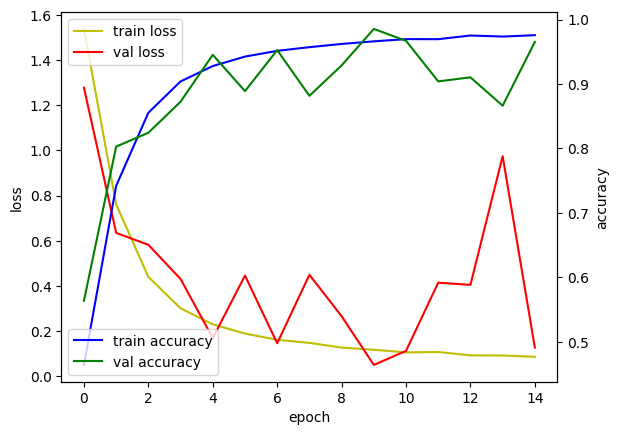

In [10]:
initial_learning_rate = 0.001 # 초기 학습률 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True) # 조금씩 학습률을 조정해나가기
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) # adam을 옵티마이저로 사용하면서 학습률은 위에서 설정한 거처럼 최적화 진행

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # 손실함수로 크로스엔트로피 사용

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5') # 최적의 모델 저장하는 콜백함수
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True) # 정확도가 patience 횟수만큼 오르지 않으면 바로 스탑해주는 콜백함수

hist = model.fit(x_train_scaled, y_train, batch_size=32, epochs=30, validation_data=(x_val_scaled,y_val), callbacks = [checkpoint_cb, early_stopping_cb])
# 한 번에 처리하는 이미지 수: 32개 / 50번 에포크 돌릴건데 콜백함수 쓰면 30번까지 안돌아감

best_model = tf.keras.models.load_model('best-cnn-model.h5') # 최적의 모델을 변수에 저장

score = best_model.evaluate(x_test_scaled, y_test, verbose=0) # 최적 모델에 대한 테스트 점수 출력

print('Test loss:', score[0])
print('Test accuracy:', score[1])


# 학습 결과 시각화를 위해 plt 사용

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

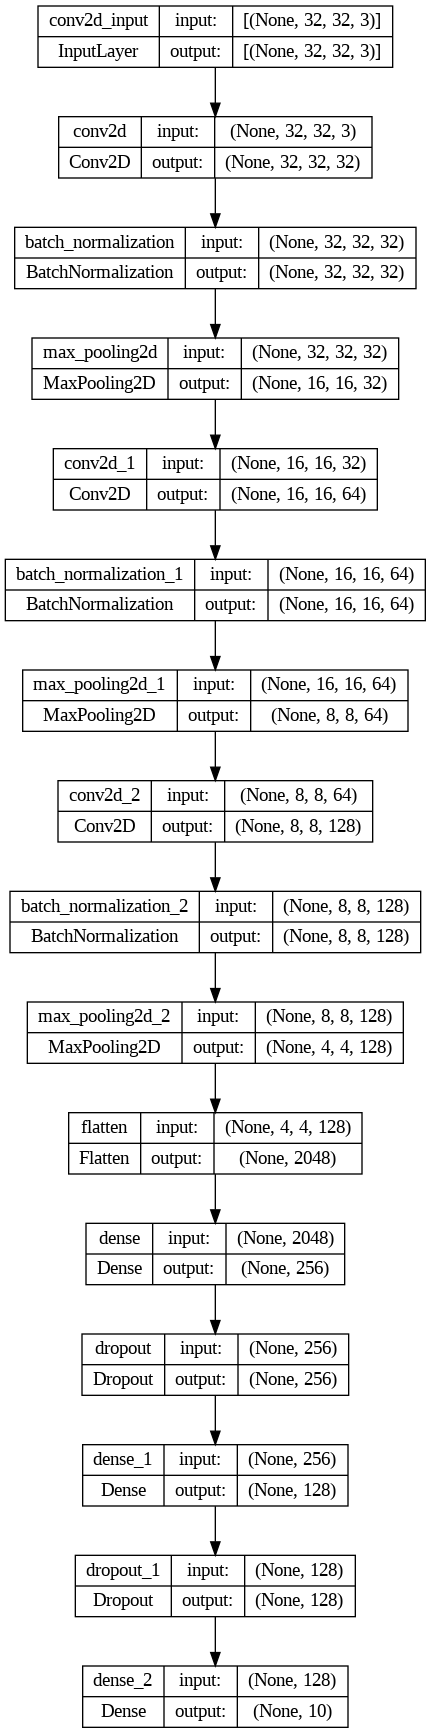

In [11]:
plot_model(best_model, show_shapes=True, to_file='model.png') # 최적 모델 구조 시각화

In [22]:
# 구글에 있는 샌드위치 이미지 들고와서 테스트 해보기

# 이미지 경로
image_path = '/content/drive/MyDrive/인지개/샌드위치 예시 이미지.jpg'

# 이미지 읽기
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 이미지 리사이즈
img = cv2.resize(img, (32, 32))

img = img.reshape((1,32,32,3))

# 이미지 어레이화
img = np.array(img)

# 이미지 정규화
img = img.astype("float32") / 255.0

# 예측
predictions = best_model.predict(img)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# 결과 출력
print("Predicted class:", food_list[predicted_class])
print("Confidence:", confidence)

# 100프로 확률로 샌드위치 예측


1/1 [==============================] - 0s 30ms/step
Predicted class: sandwich
Confidence: 1.0


In [23]:
# 구글에 있는 프라이드 누들 이미지 들고와서 테스트 해보기

# 이미지 경로
image_path = '/content/drive/MyDrive/인지개/fried_noodle 예시 이미지.jpg'  

# 이미지 읽기
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 이미지 리사이즈
img = cv2.resize(img, (32, 32))

img = img.reshape((1,32,32,3))

# 이미지 어레이화
img = np.array(img)

# 이미지 정규화
img = img.astype("float32") / 255.0

# 예측
predictions = best_model.predict(img)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# 결과 출력
print("Predicted class:", food_list[predicted_class])
print("Confidence:", confidence)

# 100프로 확률로 프라이드 누들 예측


1/1 [==============================] - 0s 22ms/step
Predicted class: fried_noodle
Confidence: 1.0
